This Notebook has been created for the ESO Stellar Coffee of 15th September 2025.

My goals are:
 * introduce the Observatorio Astrofísico de Javalambre
 * introduce the J-Surveys (J-PLUS, J-VAR, and J-PAS)
 * introduce some concepts of the Virtual Observatory
 * illustrate a programmatic VO-based dataflow for SED inspection

# Stars in the J-Surveys

The Observatorio Astrofísico de Javalambre (OAJ) is an observing facility in East Spain.
It is [located at 1956m above sea level at the Pico del Buitre, in the Sierra de Javalambre](https://maps.app.goo.gl/aXB21PYUsx6hcem59), in the province of Teruel.

<img src="960px-Astrophysical_Observatory_of_Javalambre.jpg"  />

The OAJ hosts two main telescopes:
 * the Javalambre Auxiliary Survey Telescope; an 80cm (f/4.5) telescope, equipped with T80Cam, a camera with a 2sq.deg. fielf of view and a pixel of 0.55"
 * the Javalambre Survey Telescope; a 2.5m (f/3.5) telescope, equipped with JPCam, a camera of 15 CCDs, each with a field of view of 0.5x0.5 square degrees and a pixel of 0.22"

The OAJ is managed and operated by the [Centro de Estudios de Física del Cosmos de Aragón (CEFCA)](https://www.cefca.es/), whose [headquarters are in Teruel, Spain](https://maps.app.goo.gl/4iWE1Yu5uxJSorVx7).

## The Surveys

The two telescopes host different surveys. I am going to speak only about three of them:

* JAST80
    * J-PLUS - covers 8500 sq.deg. in 12 filters
    * J-VAR - revisits 11 times the fields already covered by J-PLUS
* JST250
    * J-PAS - covers 8500 sq.deg. in 56 narrow band filters

The data of these surveys (and more) are available through [the CEFCA catalogues portal](https://archive.cefca.es/catalogues/)

In [126]:
# let's import the usual suspects
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvo
from mocpy import MOC, WCS
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.io import fits

import pyvo.dal
from pyvo.auth import authsession, securitymethods
import getpass
import requests

# To avoid warnings
import warnings
warnings.simplefilter("ignore")



### The J-PLUS filter system

The following block has been written by ChatGPT in about 2 minutes.

In [164]:

"""
Plot passbands for J-PLUS or J-PAS using VO services.

- Colors:    J-PLUS/J-PAS TAP (field: color_representation)
- Curves:    SVO Filter Profile Service (FPS)
- Output:    <prefix>.png, <prefix>.pdf, and optional <prefix>.csv

Usage:
    plot_passbands("J-PLUS")
    plot_passbands("J-PAS", out_prefix="jpas_filters", with_csv=True)
"""

import re
import sys
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astroquery.svo_fps import SvoFps
import pyvo as vo


# ----------------------------
# Config for the two surveys
# ----------------------------
SURVEY_CFG = {
    "J-PLUS": {
        # try these TAP endpoints in order
        "tap_urls": [
            "https://archive.cefca.es/catalogues/vo/tap/jplus-dr3",
            "https://archive.cefca.es/catalogues/vo/tap/jplus-dr2",
        ],
        # SVO FPS ID patterns to try for each short name
        "svo_id_patterns": [
            "OAJ/J-PLUS.{name}",
            "OAJ/JPLUS.{name}",
            "J-PLUS/{name}",
        ],
    },
    "J-PAS": {
        "tap_urls": [
            "https://archive.cefca.es/catalogues/vo/tap/jpas-edr",
            "https://archive.cefca.es/catalogues/vo/tap/jpas-idr202406",
        ],
        "svo_id_patterns": [
            "OAJ/J-PAS.{name}",
            "OAJ/JPAS.{name}",
            "J-PAS/{name}",
            "JPAS/{name}",
        ],
    },
}


# ----------------------------
# Utilities
# ----------------------------
def _parse_color(s):
    """
    Accept '#RRGGBB' or 'R,G,B' (0-255) or a matplotlib named color.
    Return hex string or (r,g,b) in 0..1, or None.
    """
    if s is None:
        return None
    s = str(s).strip()
    if not s:
        return None

    if s.startswith("#") and re.fullmatch(r"#([0-9A-Fa-f]{6})", s):
        return s

    if re.fullmatch(r"\s*\d{1,3}\s*,\s*\d{1,3}\s*,\s*\d{1,3}\s*", s):
        r, g, b = (int(x) for x in s.split(","))
        return (np.clip(r, 0, 255) / 255.0,
                np.clip(g, 0, 255) / 255.0,
                np.clip(b, 0, 255) / 255.0)
    return s  # maybe a named color; let matplotlib handle it


def _connect_tap(tap_urls):
    """
    Try a list of TAP endpoints until one responds.
    Return a pyvo TAPService.
    """
    last_exc = None
    for url in tap_urls:
        try:
            svc = vo.dal.TAPService(url)
            # light ping: list tables (doesn't pull all metadata)
            _ = list(svc.tables.keys())
            return svc
        except Exception as exc:
            last_exc = exc
            continue
    raise RuntimeError(f"Could not connect to any TAP URL. Last error: {last_exc}")


def _find_filters_table(service):
    """
    From TAP_SCHEMA, find a table that has 'color_representation' and a name-ish column.
    Return (table_name, name_column).
    """
    q_tables = """
        SELECT DISTINCT table_name
        FROM TAP_SCHEMA.columns
        WHERE LOWER(column_name) = 'color_representation'
    """
    tables = [r["table_name"] for r in service.search(q_tables).to_table()]
    if not tables:
        raise RuntimeError("No table exposes 'color_representation' in TAP_SCHEMA.")

    name_candidates = ["filter_shortname", "filter", "filter_name",
                       "shortname", "short_name", "name", "band"]

    for tname in tables:
        q_cols = f"""
            SELECT column_name
            FROM TAP_SCHEMA.columns
            WHERE table_name = '{tname}'
        """
        cols = [str(r["column_name"]) for r in service.search(q_cols).to_table()]
        low = [c.lower() for c in cols]
        match = None
        for cand in name_candidates:
            if cand in low:
                match = cols[low.index(cand)]
                break
        if match:
            return tname, match

    raise RuntimeError("Found tables with 'color_representation' but none had an obvious filter name column.")


def _fetch_filter_colors_and_names(service):
    """
    Using the located filters table, read (name, color_representation).
    Returns (names_list, colors_dict)
        - names_list: ordered as in the table (we'll later sort by λ_eff anyway)
        - colors_dict: {normalized_name -> matplotlib_color}
    """
    table_name, name_col = _find_filters_table(service)
    q = f"SELECT {name_col} AS fname, color_representation FROM {table_name}"
    tab = service.search(q).to_table()

    names = []
    color_map = {}
    for row in tab:
        fname = str(row["fname"]).strip()
        if not fname:
            continue
        names.append(fname)
        col = _parse_color(row["color_representation"])
        if col is not None:
            for k in {fname, fname.replace(" ", ""), fname.upper(), fname.lower()}:
                color_map[k] = col
    # deduplicate names preserving order
    seen = set()
    unique_names = []
    for n in names:
        if n not in seen:
            unique_names.append(n)
            seen.add(n)
    return unique_names, color_map


def _get_fps_curve(shortname, patterns):
    """
    Try each FPS ID pattern with {name}=shortname. Return (filter_id, table).
    Table columns: 'Wavelength' [Angstrom], 'Transmission' [0..1].
    """
    last_exc = None
    for patt in patterns:
        fid = patt.format(name=shortname)
        try:
            t = SvoFps.get_transmission_data(fid)
            if "Wavelength" in t.colnames and "Transmission" in t.colnames:
                return fid, t
        except Exception as exc:
            last_exc = exc
            continue
    # try a few relaxed variants of the name (spaces/no spaces, case)
    alt_names = {shortname,
                 shortname.replace(" ", ""),
                 shortname.upper(),
                 shortname.lower()}
    for nm in alt_names:
        for patt in patterns:
            fid = patt.format(name=nm)
            try:
                t = SvoFps.get_transmission_data(fid)
                if "Wavelength" in t.colnames and "Transmission" in t.colnames:
                    return fid, t
            except Exception:
                continue
    raise RuntimeError(f"FPS curve not found for '{shortname}'. Last error: {last_exc}")


def _lambda_eff(w, t):
    """Intensity-weighted mean wavelength (Å)."""
    w = np.asarray(w, float)
    t = np.asarray(t, float)
    s = t.sum()
    return (w * t).sum() / s if s > 0 else np.nan


# ----------------------------
# Main user-facing function
# ----------------------------
def plot_passbands(
    survey: str,
    out_prefix: str = None,
    with_csv: bool = False,
    fill_alpha: float = 0.28,
    line_width: float = 1.6,
):
    """
    Plot passbands for 'J-PLUS' or 'J-PAS'.

    Parameters
    ----------
    survey : {'J-PLUS','J-PAS'}
        Which survey to plot.
    out_prefix : str or None
        Prefix for output files. Defaults to 'jplus_filters' or 'jpas_filters'.
    with_csv : bool
        If True, also write a CSV with λ_eff and T_peak.
    fill_alpha : float
        Alpha for the filled area under each curve.
    line_width : float
        Line width for the passband curves.
    """
    s = survey.strip().upper()
    if s not in SURVEY_CFG:
        raise ValueError("survey must be 'J-PLUS' or 'J-PAS'")

    cfg = SURVEY_CFG[s]
    if out_prefix is None:
        out_prefix = "jplus_filters" if s == "J-PLUS" else "jpas_filters"

    # 1) TAP: colors + names
    svc = _connect_tap(cfg["tap_urls"])
    names, color_map = _fetch_filter_colors_and_names(svc)

    # 2) FPS: curves
    series = []
    skipped = []
    for name in names:
        try:
            fid, tab = _get_fps_curve(name, cfg["svo_id_patterns"])
            w = np.array(tab["Wavelength"], dtype=float)          # Å
            T = np.array(tab["Transmission"], dtype=float) * 100  # %
            col = (color_map.get(name)
                   or color_map.get(name.upper())
                   or color_map.get(name.lower())
                   or color_map.get(name.replace(" ", "")))
            leff = _lambda_eff(w, T / 100.0)
            series.append(dict(name=name, fid=fid, w=w, T=T, color=col, leff=leff))
        except Exception as e:
            skipped.append((name, str(e)))
            continue

    if not series:
        raise SystemExit(f"No passbands fetched for {survey}. Aborting.")

    # 3) sort and plot
    series.sort(key=lambda d: (np.isnan(d["leff"]), d["leff"]))
    fig, ax = plt.subplots(figsize=(12.0, 4.0))

    for sdat in series:
        ax.fill_between(
            sdat["w"], sdat["T"],
            step="mid", alpha=fill_alpha if sdat["color"] is not None else 0.18,
            color=sdat["color"], linewidth=0
        )
        ax.plot(sdat["w"], sdat["T"], lw=line_width, color=sdat["color"])

    ax.set_xlabel(r"$\lambda\;(\mathrm{\AA})$")
    ax.set_ylabel(r"$T\;(\%)$")
    ax.set_ylim(0, 105)

    allw = np.concatenate([d["w"] for d in series])
    lo, hi = np.nanpercentile(allw, 1), np.nanpercentile(allw, 99)
    pad = 0.03 * (hi - lo)
    ax.set_xlim(lo - pad, hi + pad)

    ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.6)
    plt.tight_layout()

    png = f"{out_prefix}.png"
    pdf = f"{out_prefix}.pdf"
    #fig.savefig(png, dpi=220)
    #fig.savefig(pdf)

    # 4) optional CSV
    csv_path = None
    if with_csv:
        import csv
        csv_path = f"{out_prefix}.csv"
        with open(csv_path, "w", newline="") as f:
            wcsv = csv.writer(f)
            wcsv.writerow(["filter", "svo_id", "lambda_eff_A", "T_peak_%"])
            for d in series:
                T_peak = float(np.nanmax(d["T"]))
                wcsv.writerow([d["name"], d["fid"], f"{d['leff']:.2f}", f"{T_peak:.3f}"])

    # 5) brief stdout summary (helpful when running as a script)
    print(f"[{survey}] Saved {png} and {pdf}" + (f" and {csv_path}" if csv_path else ""))
    if skipped:
        print(f"[{survey}] Skipped {len(skipped)} filters (IDs not found on FPS):")
        for nm, why in skipped[:8]:
            print(f"   - {nm}: {why}")
        if len(skipped) > 8:
            print("   ...")

    return {"png": png, "pdf": pdf, "csv": csv_path, "skipped": skipped}


### The J-VAR filter system

[J-PLUS] Saved jplus_filters.png and jplus_filters.pdf


{'png': 'jplus_filters.png',
 'pdf': 'jplus_filters.pdf',
 'csv': None,
 'skipped': []}

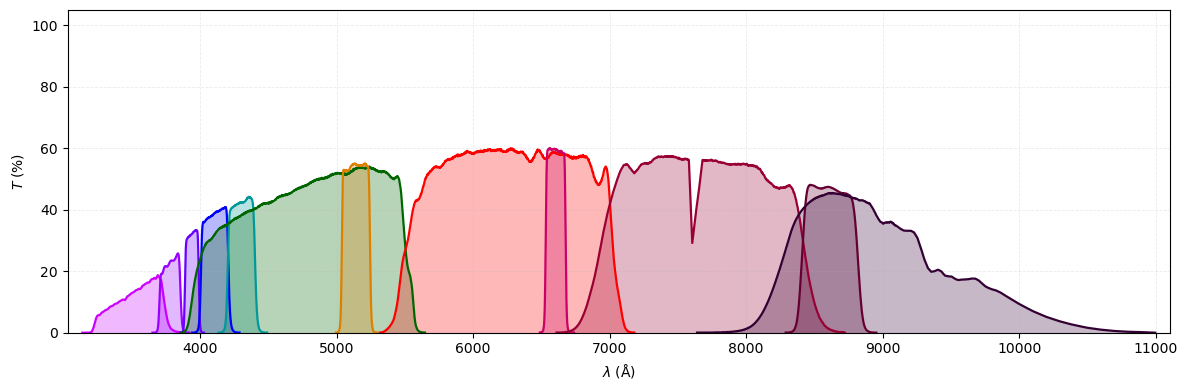

In [162]:
plot_passbands('J-PLUS', with_csv=False)


### The J-VAR filter System

J-VAR uses the most efficient filters (g,r,i,J0515,J0660, and J0861) plus the J0395 for stellar activity.

### The J-PAS filter system

[J-PAS] Saved jpas_filters.png and jpas_filters.pdf


{'png': 'jpas_filters.png',
 'pdf': 'jpas_filters.pdf',
 'csv': None,
 'skipped': []}

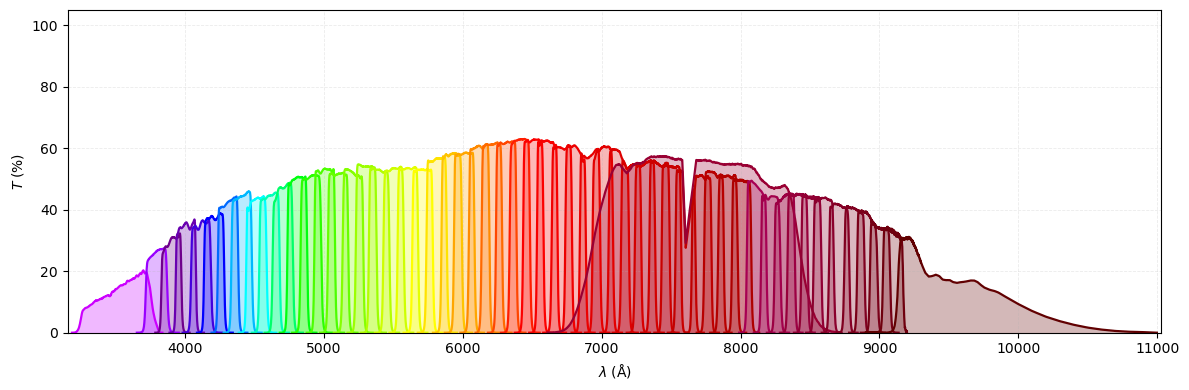

In [165]:
plot_passbands('J-PAS', with_csv=False)


## Using MOCs

A "multi-order coverage" (MOC) map is a way to visualise the footprint of an astronomical observation. You can store MOCs in fits files and you can easily handle them in Aladin or Python.

A great tutorial by Pedro Mas Buitrago can be found [here](https://colab.research.google.com/drive/1CehMdQLCb98PEFmzRBdm7mYycS6fJH59?usp=sharing#scrollTo=detected-faculty)

In [18]:
moc_jplusdr3 = MOC.from_fits("data/J-PLUS-DR3_moc.fits")
moc_jpasidr202406 = MOC.from_fits("data/JPAS-IDR202406_moc.fits")
fits_jvarpointings = fits.open('data/jvar_dr1_pointings.fits')
pointings_jvardr1 = fits_jvarpointings[1].data


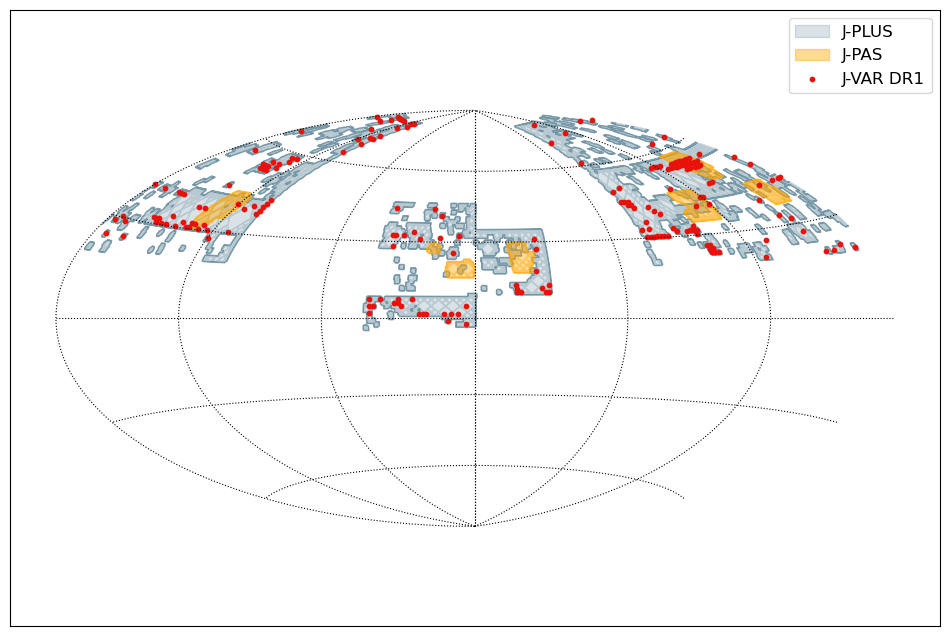

In [ ]:
fig = plt.figure(figsize=(12,8))

with WCS(fig,
         fov = 240*u.deg,
         center=SkyCoord(0,0,unit='deg',frame='icrs'),
         coordsys='icrs', rotation=Angle(0, u.degree),
         projection='AIT') as wcs:

    ax = fig.add_subplot(projection=wcs)

    moc_jplusdr3.fill(ax=ax, wcs=wcs, alpha=0.15, fill=True,color='#003f5c', label= 'J-PLUS')
    moc_jplusdr3.border(ax=ax, wcs=wcs, alpha=0.4, color='#003f5c')

    moc_jpasidr202406.fill(ax=ax, wcs=wcs, alpha=0.4, fill=True, color='#ffa600', label='J-PAS')
    moc_jpasidr202406.border(ax=ax, wcs=wcs, alpha=0.6, color='#ffa600')

    ax.scatter(pointings_jvardr1['RA'],pointings_jvardr1['DEC'],marker='o',color="#e9120b",s=10,transform=ax.get_transform('world'),label='J-VAR DR1')

ax.legend(fontsize=12)
plt.grid(color='black', linestyle='dotted')

plt.show()
warnings.filterwarnings('ignore')

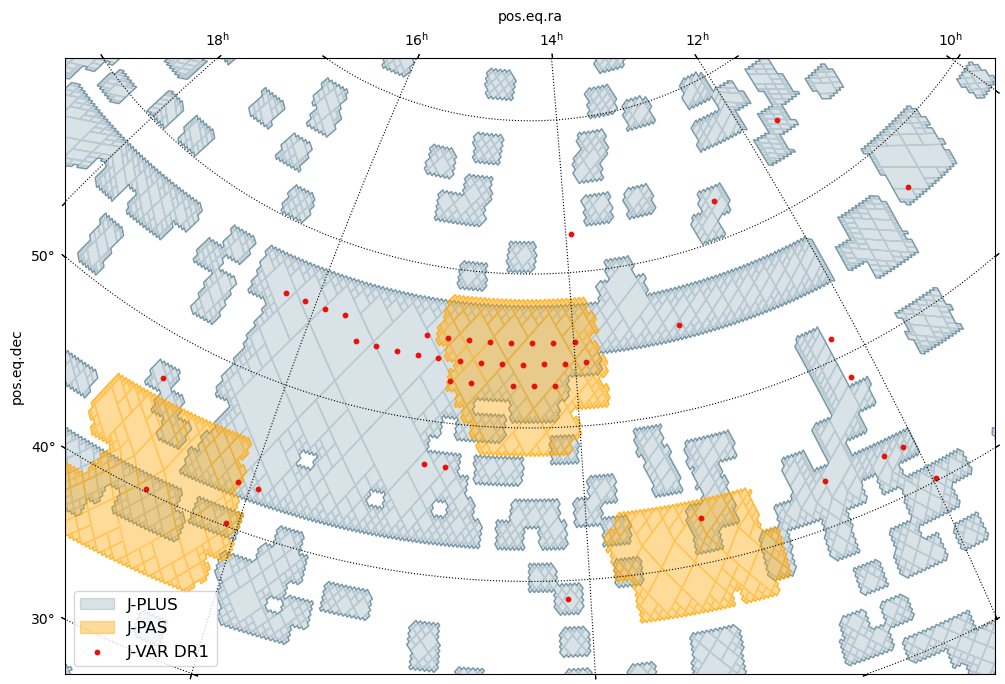

In [32]:
fig = plt.figure(figsize=(12,8))

with WCS(fig,
         fov = 40*u.deg,
         center=SkyCoord(215,54,unit='deg',frame='icrs'),
         coordsys='icrs', rotation=Angle(0, u.degree),
         projection='AIT') as wcs:

    ax = fig.add_subplot(projection=wcs)

    moc_jplusdr3.fill(ax=ax, wcs=wcs, alpha=0.15, fill=True,color='#003f5c', label= 'J-PLUS')
    moc_jplusdr3.border(ax=ax, wcs=wcs, alpha=0.4, color='#003f5c')

    moc_jpasidr202406.fill(ax=ax, wcs=wcs, alpha=0.4, fill=True, color='#ffa600', label='J-PAS')
    moc_jpasidr202406.border(ax=ax, wcs=wcs, alpha=0.6, color='#ffa600')

    ax.scatter(pointings_jvardr1['RA'],pointings_jvardr1['DEC'],marker='o',color="#e9120b",s=10,transform=ax.get_transform('world'),label='J-VAR DR1')

ax.legend(fontsize=12)
plt.grid(color='black', linestyle='dotted')

plt.show()
warnings.filterwarnings('ignore')

# Browsing the database

All the information of J-PLUS, J-VAR, and J-PAS are stored in relational databases. 

Accessing a database can be daunting if you have never done it.

An easy way is just to access it online:

 * [J-PLUS](https://archive.cefca.es/catalogues/jplus-dr3/help_adql.html)
 * [J-VAR](https://archive.cefca.es/catalogues/jvar-dr1/help_adql.html)
 * [J-PAS](https://archive.cefca.es/catalogues/jpas-idr202406/help_adql.html)

There are three ways of browsing the database.

## the web interface

If you click on the above links, you are directed to the help of the database of each survey and you can (should) read the description of each table and each row.

## TOPCAT

This is for advanced users. Open TOPCAT and find the "Query remote databases using SQL-lite language". 
In keywords, type "CEFCA" and you will see what we are offering.
Select one, click on "use service" and you will be able to browse through the different tables.

## Python

This is for advanced (and slightly masochistic) users. I will show it in the following cell.

In [34]:
tap = pyvo.dal.TAPService("https://archive.cefca.es/catalogues/vo/tap/jplus-dr3")

# list tables
tables = tap.search("SELECT schema_name, table_name, description FROM TAP_SCHEMA.tables")
for r in tables.table:
    print(r["schema_name"], r["table_name"], r["description"])



jplus jplus.DuplicatedMagABSingleObj Table that contains the main parameters of the astronomical duplicated objects detected in the images. The sources listed in this table have been considered duplicated detections as they are at the same location of another detection in an adjacent image that has better data quality. Only the counterpart with lower quality is listed in this table. Magnitude data is adjusted by the image Zero Point and is in magnitude AB units.
jplus jplus.FNuDualPointSources This table contains the total fluxes assuming that the detected sources in the dual catalogue are point-like (e.g., stars or quasars). These fluxes are not suitable to analyze extended sources (e.g., galaxies). Different strategies have been used to derive the total fluxes, as detailed in the table columns. Array columns (type[]) contains measures for each filter (NULL if the image in the filter is not available). Enumeration 'jplus' can be used to refer filter positions in the array. Flux data i

In [36]:
# describe columns of a table
cols = tap.search("""
    SELECT column_name, datatype, unit, ucd, description
    FROM TAP_SCHEMA.columns
    WHERE table_name='jplus.Filter'
""")
print(cols.to_table().pprint(max_lines=-1))



    column_name      ...
-------------------- ...
           filter_id ...
                name ...
          wavelength ...
               width ...
                  kx ...
color_representation ...
None


In [37]:
# sample data
rows = tap.search("SELECT TOP 5 * FROM jplus.Filter")
print(rows.to_table())

filter_id  name wavelength width   kx  color_representation
                 Angstrom    nm                            
--------- ----- ---------- ----- ----- --------------------
        1 rSDSS       6250  1250 2.383              #FF0000
        2 gSDSS       4750  1250 3.398              #006600
        3 iSDSS       7725  1250 1.743              #990033
        4 zSDSS       9150  1300 1.289              #330033
        5 uJAVA       3485   458 4.479              #CC00FF


# The J-PLUS Tile 2435

It seems that this tile belongs to the three surveys.
Let's have some fun.

Although the field is called 2435, the "tile" has a different name. This can be a bit confusing, especially if you have been in J-PLUS/J-PAS for the past 12 years.

In [31]:
tap = pyvo.dal.TAPService("https://archive.cefca.es/catalogues/vo/tap/jplus-dr3")

tmp = tap.search("SELECT TILE_ID,REF_TILE_ID,NAME,RA,DEC FROM TileImage where RA between 215 and 216 and DEC between 54 and 55")

print(tmp.to_table)


<bound method DALResults.to_table of <DALResultsTable length=12>
tile_id ref_tile_id                  name                    ra      dec  
                                                            deg      deg  
 int32     int32                    object                float64  float64
------- ----------- ------------------------------------- -------- -------
  94581       94587 1000001-JPLUS-02435-v202202_iSDSS_swp 215.7758 54.1133
  94582       94587 1000001-JPLUS-02435-v202202_uJAVA_swp 215.7758 54.1133
  94583       94587 1000001-JPLUS-02435-v202202_J0861_swp 215.7758 54.1133
  94584       94587 1000001-JPLUS-02435-v202202_J0430_swp 215.7758 54.1133
  94585       94587 1000001-JPLUS-02435-v202202_J0515_swp 215.7758 54.1133
  94586       94587 1000001-JPLUS-02435-v202202_J0410_swp 215.7758 54.1133
  94588       94587 1000001-JPLUS-02435-v202202_J0378_swp 215.7758 54.1133
  94589       94587 1000001-JPLUS-02435-v202202_J0660_swp 215.7758 54.1133
  94590       94587 1000001-JPLUS-0

## explore the tile

the first thing I want to know is how many objects there are

In [39]:
myQuery = ''' 
select count(*) from jplus.MagABDualObj where tile_id = 94587
 '''
tmp = tap.search(myQuery)

print(tmp.to_table)

<bound method DALResults.to_table of <DALResultsTable length=1>
_exp1
int32
-----
33994>


how many of these objects are already in Gaia?
I could do a query with Gaia but it is already available in the database.
It is just a slightly more complex query.

In [43]:
myQuery = ''' 
select count(jp.number) 
from jplus.MagABDualObj as jp
join jplus.xmatch_gaia_dr3 as gaia on gaia.number = jp.number and gaia.tile_id = jp.tile_id
where jp.tile_id = 94587
 '''
tmp = tap.search(myQuery)

print(tmp.to_table)

<bound method DALResults.to_table of <DALResultsTable length=1>
_exp1
int32
-----
 6114>


...and how many objects have an invertible parallax?

In [59]:
myQuery = ''' 
select count(jp.number) 
from jplus.MagABDualObj as jp
join jplus.xmatch_gaia_dr3 as gaia on gaia.number = jp.number and gaia.tile_id = jp.tile_id
where 
jp.tile_id = 94587
and abs(e_Plx/Plx) < 0.2
 '''
tmp = tap.search(myQuery)

print(tmp.to_table)

<bound method DALResults.to_table of <DALResultsTable length=1>
_exp1
int32
-----
 2184>


Let us look at these 2184 beauties

In [54]:
myQuery = ''' 
select jp.*,gaia.*
from jplus.MagABDualObj as jp
join jplus.xmatch_gaia_dr3 as gaia on gaia.number = jp.number and gaia.tile_id = jp.tile_id
where 
jp.tile_id = 94587
and abs(e_Plx/Plx) < 0.2
 '''
tmp = tap.search(myQuery)

jplusdr3_gaia_table = tmp.to_table()

In [55]:
print(jplusdr3_gaia_table.info())

<Table length=2184>
         name           dtype  shape      unit                                                                                      description                                                                                   n_bad
---------------------- ------- ----- ------------- ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ -----
               tile_id   int32                                                                                                                                         Identifier of the Tile image where the object was detected     0
                number   int32                                                                                                                               Number identifier assigned by Sextractor for the object in the image     0
           alpha_j2000 float64                 deg  

careful with the columns which have shape (12,)

let's make an easy colour magnitude diagram

tile_id number    alpha_j2000        delta_j2000    ... pgal   pss   teff
                      deg                deg        ...               K  
------- ------ ------------------ ----------------- ... ---- ------- ----
  94587  26743 216.02588543852443 54.53170165882941 ...  0.0 1.3e-05   --


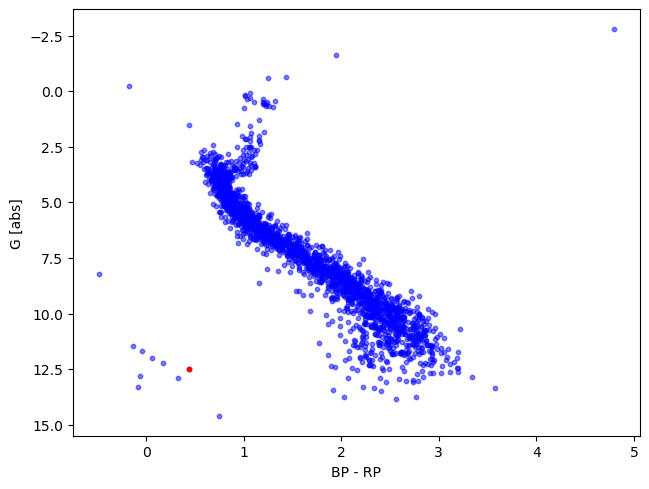

In [73]:
x = jplusdr3_gaia_table['bp_rp']
y = jplusdr3_gaia_table['gmag'] + 5 - 5 * np.log10( 1000./jplusdr3_gaia_table['plx'] )

interesting = jplusdr3_gaia_table[ (y > 12.5) & (y < 12.6) ]
#interesting = interesting[ interesting['gmag'] + 5 - 5 * np.log(1000/interesting['plx']) < 13 ]
interesting = interesting[ interesting['bp_rp'] < 1 ]
interesting = interesting[ interesting['bp_rp'] > 0 ]
interesting_x = interesting['bp_rp']
interesting_y = interesting['gmag'] + 5 - 5 * np.log10( 1000./interesting['plx'] )


plt.scatter(x,y,s=10,alpha=0.5,c='b')
plt.scatter(interesting_x,interesting_y,s=10,alpha=1,c='r')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.xlabel('BP - RP')
plt.ylabel('G [abs]')

print(interesting)

in order to get the stars which are well observed by the three surveys, I am going to select whose who have G between 16 and 18 mag

Text(30.972222222222214, 0.5, 'G [abs]')

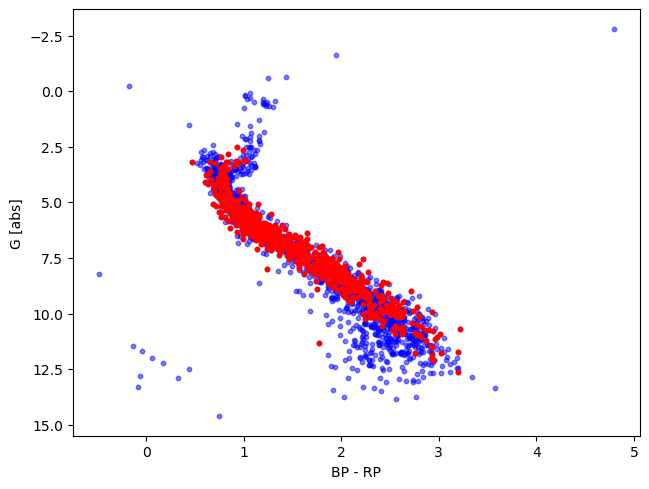

In [98]:
x = jplusdr3_gaia_table['bp_rp']
y = jplusdr3_gaia_table['gmag'] + 5 - 5 * np.log10( 1000./jplusdr3_gaia_table['plx'] )

interesting = jplusdr3_gaia_table[ (jplusdr3_gaia_table['gmag'] > 16) & (jplusdr3_gaia_table['gmag'] < 18) ]
interesting_x = interesting['bp_rp']
interesting_y = interesting['gmag'] + 5 - 5 * np.log10( 1000./interesting['plx'] )


plt.scatter(x,y,s=10,alpha=0.5,c='b')
plt.scatter(interesting_x,interesting_y,s=10,alpha=1,c='r')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.xlabel('BP - RP')
plt.ylabel('G [abs]')

let's focus on that star right under the main sequence at about G[abs] ~ 8 and BP - RP ~ 1.2

2
2
tile_id number    gmag    bp_rp  
                  mag      mag   
------- ------ --------- --------
  94587  10465 17.511326 1.463778
  94587  25466  17.85879 1.241638


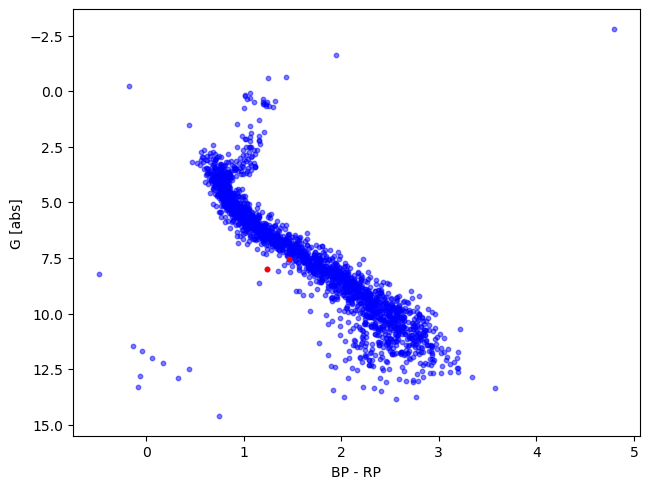

In [101]:
x = jplusdr3_gaia_table['bp_rp']
y = jplusdr3_gaia_table['gmag'] + 5 - 5 * np.log10( 1000./jplusdr3_gaia_table['plx'] )

print(len(interesting))
interesting = interesting[ (interesting['bp_rp'] > 1) & (interesting['bp_rp'] < 1.5) ]
print(len(interesting))
interesting = interesting[ (interesting['gmag'] + 5 - 5 * np.log10(1000/interesting['plx']) > 7.5)] # & (interesting['gmag'] + 5 - 5 * np.log10(1000/interesting['plx'] < 9)) ]
interesting_x = interesting['bp_rp']
interesting_y = interesting['gmag'] + 5 - 5 * np.log10( 1000./interesting['plx'] )


plt.scatter(x,y,s=10,alpha=0.5,c='b')
plt.scatter(interesting_x,interesting_y,s=10,alpha=1,c='r')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.xlabel('BP - RP')
plt.ylabel('G [abs]')

print(interesting['tile_id','number','gmag','bp_rp'])

we all download a fits file with the content of the "filter" table of the database

```sql
select *
from filter
```

In [74]:
with fits.open('data/filterset_jplus.fits') as hdu:
    filterset = Table(hdu[1].data)
display(filterset)


FILTER_ID,name,wavelength,width,kx,color_representation
int32,str5,int32,int32,float64,str7
1,rSDSS,6250,1250,2.383,#FF0000
2,gSDSS,4750,1250,3.398,#006600
3,iSDSS,7725,1250,1.743,#990033
4,zSDSS,9150,1300,1.289,#330033
5,uJAVA,3485,458,4.479,#CC00FF
6,J0378,3785,138,4.294,#9900FF
7,J0395,3950,70,4.226,#6600FF
8,J0410,4100,170,4.023,#0000FF
9,J0430,4300,170,3.859,#009999


Text(0.5, 1.0, 'J-PLUS  : 94587-25466')

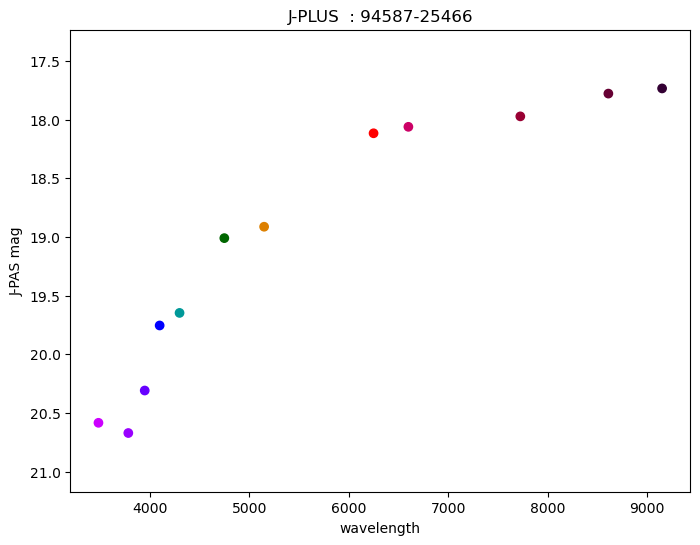

In [102]:

one_object = interesting[ (interesting['tile_id'] == 94587) & (interesting['number'] == 25466) ]

mag = one_object['mag_aper_3_0']

tile = one_object['tile_id'].value[0]
num = one_object['number'].value[0]

objname = 'J-PLUS '+' : '+str(tile)+'-'+str(num)

filtername = filterset['name']
wave = filterset['wavelength']
colors = filterset['color_representation']

valid_mag = mag[mag != 99]
mag_max = np.max(valid_mag)
mag_min = np.min(mag)

plt.figure(figsize=(8, 6))  
plt.scatter(wave, mag, color=colors)
plt.gca().invert_yaxis()
plt.ylim(mag_max + 0.5, mag_min - 0.5)
plt.xlabel('wavelength')
plt.ylabel('J-PAS mag')
plt.title(objname)

# J-VAR

What if one could access 1.3 million light curves in 7 colours in 11 epochs?

In [151]:
tap = pyvo.dal.TAPService("https://archive.cefca.es/catalogues/vo/tap/jvar-dr1")

selected_obj_id = '94587-25466'

this_query = f"SELECT * FROM jvar.Light_curves WHERE obj_id = \'{selected_obj_id}\'"

tmp = tap.search(this_query)

one_object_lightcurve = tmp.to_table()

In [152]:
this_query = f"SELECT * FROM jvar.Objects WHERE obj_id = \'{selected_obj_id}\'"

tmp = tap.search(this_query)

jvar_object = tmp.to_table()

print(jvar_object['obj_id','vsx_type','vsx_period','gaia_class','gaia_score'])

   obj_id   vsx_type vsx_period gaia_class gaia_score
----------- -------- ---------- ---------- ----------
94587-25466      N/A        0.0        N/A       -1.0


In [153]:
print(one_object_lightcurve.colnames)
print(one_object_lightcurve['filter'])

['obj_id', 'ra', 'dec', 'hpix11', 'field', 'filter', 'mag', 'mag_err', 'flags', 'fwhm', 'corr_curves', 'mjd']
filter
------
 GSDSS
 ISDSS
 J0515
 J0660
 J0861
 RSDSS


GSDSS
RSDSS
ISDSS
J0395
J0515
J0660
J0861


Text(0, 0.5, 'g')

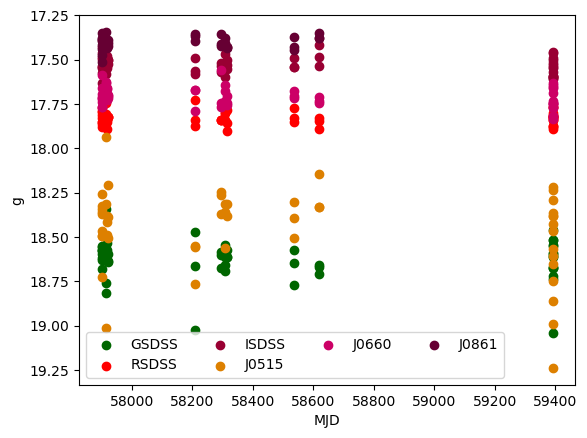

In [ ]:
filter_colors = {'GSDSS':'#006600', 'RSDSS':'#FF0000', 'ISDSS':'#990033', 'J0395':'#6600FF', 'J0515':'#DD8000', 'J0660':'#CC0066', 'J0861':'#660033'}
for eachcolor in filter_colors:
    print(eachcolor)
    thisBandLC = one_object_lightcurve[ one_object_lightcurve['filter'] == eachcolor ]
    thisShape = thisBandLC['mjd'].shape[0]
    if thisShape > 0:
        mjds = thisBandLC['mjd'].data[0]
        mags = thisBandLC['mag'].data[0]
        my_mjds = mjds[mags < 99]
        my_mags = mags[mags < 99]
        plt.scatter(my_mjds,my_mags,c=filter_colors[eachcolor],label=eachcolor)
#
plt.gca().invert_yaxis()
plt.legend(ncols=4)
plt.xlabel('MJD')
plt.ylabel('g')

# J-PAS

let's look at the spectrum... this will be fun

In [134]:
# Url of the TAP service
tap_url = "https://archive.cefca.es/catalogues/vo/tap/jpas-idr202406"

In [135]:
# Login
user = input("Username:")
pwd = getpass.getpass("Password:")
archive_login_url = "https://archive.cefca.es/catalogues/login"
login_args = {"login": user, "password": pwd,
              "submit": "Sign+In"}
login_header = {"Content-type": "application/x-www-form-urlencoded",
                "Accept": "text/plain"}

pyvo.dal.tap.s = requests.Session()
response = pyvo.dal.tap.s.post(archive_login_url,
                 data=login_args, headers=login_header)
response.raise_for_status()
auth = authsession.AuthSession()
auth.credentials.set(securitymethods.ANONYMOUS, pyvo.dal.tap.s)

In [138]:
# Executing your query
service = pyvo.dal.TAPService(tap_url, session=auth)

selected_obj_tile = '94587'
selected_obj_number = '25466'

this_query = f"SELECT *  \
FROM jpas.MagABDualObj as jpasdm \
join jpas.xmatch_jplus_dr3 as jplus on \
jplus.JPAS_TILE_ID = jpasdm.tile_id and jplus.JPAS_NUMBER = jpasdm.number \
WHERE jplus.JPLUSDR3_TILE_ID = {selected_obj_tile} and jplus.JPLUSDR3_NUMBER = {selected_obj_number}"

print(this_query)

resultset = service.run_async(this_query)

SELECT *  FROM jpas.MagABDualObj as jpasdm join jpas.xmatch_jplus_dr3 as jplus on jplus.JPAS_TILE_ID = jpasdm.tile_id and jplus.JPAS_NUMBER = jpasdm.number WHERE jplus.JPLUSDR3_TILE_ID = 94587 and jplus.JPLUSDR3_NUMBER = 25466


DALServiceError: No result URI available

Since I am getting troubles... I did the query in the portal and I continue with the fits file that I downloaded.

In [139]:
with fits.open('data/jpas_94587-25466.fits') as hdu:
    one_object_jpas = Table(hdu[1].data)

print(one_object_jpas.colnames)

['TILE_ID', 'NUMBER', 'ALPHA_J2000', 'DELTA_J2000', 'hpix11', 'X_IMAGE', 'Y_IMAGE', 'R_EFF', 'FWHM_WORLD', 'A_WORLD', 'B_WORLD', 'THETA_J2000', 'ISOAREA_WORLD', 'RELERRA_WORLD', 'RELERRB_WORLD', 'ERRTHETA_J2000', 'CLASS_STAR', 'MAG_AUTO', 'MAG_ISO', 'MAG_PETRO', 'MU_MAX', 'PETRO_RADIUS', 'KRON_RADIUS', 'MAG_APER_0_8', 'MAG_APER_1_0', 'MAG_APER_1_2', 'MAG_APER_1_5', 'MAG_APER_2_0', 'MAG_APER_3_0', 'MAG_APER_4_0', 'MAG_APER_6_0', 'MAG_ERR_AUTO', 'MAG_ERR_ISO', 'MAG_ERR_PETRO', 'MAG_ERR_APER_0_8', 'MAG_ERR_APER_1_0', 'MAG_ERR_APER_1_2', 'MAG_ERR_APER_1_5', 'MAG_ERR_APER_2_0', 'MAG_ERR_APER_3_0', 'MAG_ERR_APER_4_0', 'MAG_ERR_APER_6_0', 'FLAGS', 'NORM_WMAP_VAL', 'MASK_FLAGS', 'SINGLE_DETECT', 'MAG_APER_COR_3_0', 'MAG_ERR_APER_COR_3_0', 'MAG_APER_COR_6_0', 'MAG_ERR_APER_COR_6_0', 'angDist', 'JPAS_TILE_ID', 'JPAS_NUMBER', 'JPLUSDR3_TILE_ID', 'JPLUSDR3_NUMBER', 'ALPHA_J2000_1', 'DELTA_J2000_1', 'hpix11_1', 'X_IMAGE_1', 'Y_IMAGE_1', 'R_EFF_1', 'FWHM_WORLD_1', 'A_WORLD_1', 'B_WORLD_1', 'THETA_J2

In [140]:
with fits.open('data/filterset_jpas.fits') as hdu:
    jpas_filterset = Table(hdu[1].data)

display(jpas_filterset)

color_representation,filter_id,kx,name,wavelength,width
str7,int16,float64,str5,int32,int32
#CC00FF,1,4.916,uJAVA,3497,509
#9900FF,2,4.567,J0378,3782,157
#6F008C,3,4.442,J0390,3904,150
#6900B0,4,4.341,J0400,3996,148
#4300DE,5,4.241,J0410,4110,144
#0000FF,6,4.143,J0420,4203,147
#0069FF,7,4.048,J0430,4303,148
#00B8FF,8,3.953,J0440,4403,152
#00FFFF,9,3.861,J0450,4503,150


MAG_APER_COR_3_0
----------------
            99.0
            99.0
            99.0
            99.0
       19.309885
       19.301847
       19.226679
       18.967499
            99.0
            99.0
             ...
            99.0
       17.399593
            99.0
       17.384651
            99.0
       17.329458
            99.0
            99.0
       17.302994
       17.505108
Length = 57 rows
wavelength
----------
      3497
      3782
      3904
      3996
      4110
      4203
      4303
      4403
      4503
      4603
       ...
      8429
      8523
      8620
      8716
      8810
      8912
      9000
      9107
      9316
      7725
Length = 57 rows
MAG_APER_COR_3_0
----------------
       19.309885
       19.301847
       19.226679
       18.967499
       18.476128
       18.449644
       18.432861
       18.395744
       18.144228
         18.0202
             ...
       17.598946
       17.534996
       17.476162
       17.475069
        17.43798
       17.399593

Text(0.5, 1.0, 'J-PAS : 9682_25211')

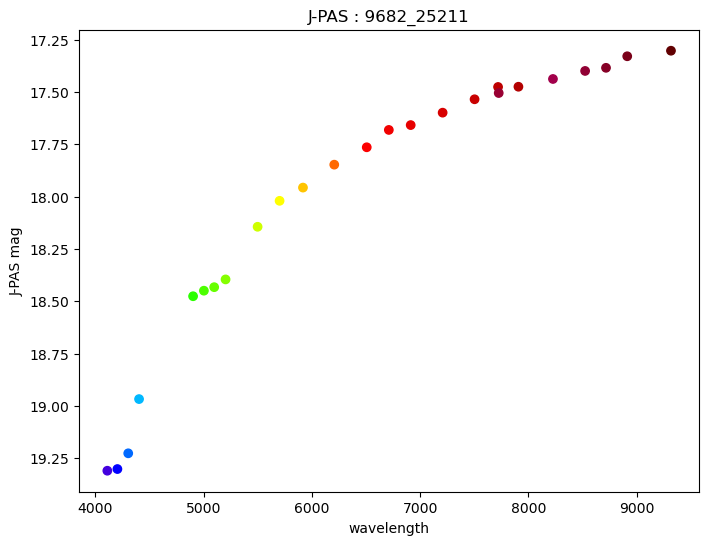

In [171]:

mag3 = one_object_jpas['MAG_APER_COR_3_0']
mag = mag3[0,:]
mag[np.isnan(mag)] = 99

tile = one_object_jpas['TILE_ID'].value[0]
num = one_object_jpas['NUMBER'].value[0]
objname = 'J-PAS : '+str(tile)+'_'+str(num)

filtername = jpas_filterset['name']
wave = jpas_filterset['wavelength']
colors = jpas_filterset['color_representation']

valid_mag = mag[mag != 99]
mag_max = np.max(valid_mag)
mag_min = np.min(mag)

print(mag)
print(wave)
print(valid_mag)

plt.figure(figsize=(8, 6))  
plt.scatter(wave[mag != 99], mag[mag!=99], color=colors[mag!=99])
#plt.ylim(mag_max + 0.5, mag_min - 0.5)
plt.gca().invert_yaxis()
plt.xlabel('wavelength')
plt.ylabel('J-PAS mag')
plt.title(objname)


# Wrap-up

Narrow-band imaging is a compromise between broad-band imaging and low-resolution spectroscopy:

* pros
    * no selection bias
    * faster than spectroscopy
* cons
    * less deep than broad-band
    * less (?) information than spectroscopy 

Virtual Observatory standards and protocols allow us to access and analyse data in a systematic way without worrying about their specificity.

Programmatic interfaces ensures repeatibility and reproducibility of results.

Quick and dirty data exploration with, e.g. TOPCAT and Aladin, is recommended and encouraged.

*Use of unnecessary violence in the apprehension of the Blues Brothers has been approved*